## Created by: Beshoy Osama

In [60]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshsaxenadn/fast-food-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fast-food-classification-dataset


In [61]:
import os
import pandas as pd

In [62]:
# Dataset directories
train_path = '/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Train'
valid_path = '/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Valid'
test_path  = '/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Test'

In [63]:
# Collect the class names
classes = sorted(list(map(lambda x: x.title(), os.listdir(train_path))))

In [73]:
# Compuet the total number of classes
n_classes = len(classes)
n_classes

10

In [64]:
file_paths = []
labels = []

# Read Train images
for class_name in classes:
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        for f in os.listdir(class_dir):
            fpath = os.path.join(class_dir, f)
            if os.path.isfile(fpath):
                file_paths.append(fpath)
                labels.append(class_name)

In [65]:
# Read Valid images
for class_name in classes:
    class_dir = os.path.join(valid_path, class_name)
    if os.path.isdir(class_dir):
        for f in os.listdir(class_dir):
            fpath = os.path.join(class_dir, f)
            if os.path.isfile(fpath):
                file_paths.append(fpath)
                labels.append(class_name)

In [66]:
# Read Test images
for class_name in classes:
    class_dir = os.path.join(test_path, class_name)
    if os.path.isdir(class_dir):
        for f in os.listdir(class_dir):
            fpath = os.path.join(class_dir, f)
            if os.path.isfile(fpath):
                file_paths.append(fpath)
                labels.append(class_name)

In [67]:
# Build DataFrame
df = pd.DataFrame({
    'filename': file_paths,
    'class': labels
})

In [82]:
df.head()

,filename,class
0,/kaggle/input/fast-food-classification-dataset...,Baked Potato
1,/kaggle/input/fast-food-classification-dataset...,Baked Potato
2,/kaggle/input/fast-food-classification-dataset...,Baked Potato
3,/kaggle/input/fast-food-classification-dataset...,Baked Potato
4,/kaggle/input/fast-food-classification-dataset...,Baked Potato


In [81]:
df['class'].value_counts()

,count
class,
Baked Potato,2000
Burger,2000
Crispy Chicken,2000
Donut,2000
Fries,2000
Hot Dog,2000
Pizza,2000
Sandwich,2000
Taco,2000


In [69]:
df.shape

(20000, 2)

In [74]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

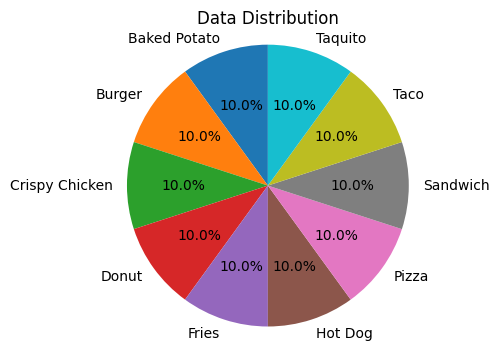

In [75]:
import seaborn as sns

class_counts = df['class'].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Data Distribution')
plt.axis('equal')
plt.show()

In [76]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [77]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [78]:
datagen_valid = ImageDataGenerator(rescale=1./255)

In [79]:
from sklearn.model_selection import train_test_split

In [83]:
# train (65%), validation (35%)
train_df, val_df = train_test_split(df, test_size=0.35, stratify=df['class'],shuffle=True ,random_state=42)

In [84]:
train_df['class'] = train_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)

In [85]:
train_df['class'].value_counts()

,count
class,
Taquito,1300
Hot Dog,1300
Baked Potato,1300
Pizza,1300
Burger,1300
Fries,1300
Crispy Chicken,1300
Donut,1300
Sandwich,1300


In [86]:
val_df['class'].value_counts()

,count
class,
Fries,700
Sandwich,700
Burger,700
Baked Potato,700
Pizza,700
Crispy Chicken,700
Donut,700
Taquito,700
Hot Dog,700


## -----------------------------------------------------------------------------------------------------------------------------------

## Create generators

In [87]:
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 13000 validated image filenames belonging to 10 classes.


In [88]:
validation_generator = datagen_valid.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7000 validated image filenames belonging to 10 classes.


## ResNet50 Model

In [98]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [113]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [114]:
base_model.trainable = True

In [115]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [116]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,123,018 (92.02 MB)

 Trainable params: 24,065,802 (91.80 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [117]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [118]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [119]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/100
407/407 ━━━━━━━━━━━━━━━━━━━━ 300s 601ms/step - accuracy: 0.5791 - loss: 1.2834 - val_accuracy: 0.1033 - val_loss: 2.6659
Epoch 2/100
407/407 ━━━━━━━━━━━━━━━━━━━━ 215s 529ms/step - accuracy: 0.8407 - loss: 0.5252 - val_accuracy: 0.7011 - val_loss: 0.9524
Epoch 3/100
407/407 ━━━━━━━━━━━━━━━━━━━━ 214s 527ms/step - accuracy: 0.8764 - loss: 0.4180 - val_accuracy: 0.8499 - val_loss: 0.5451
Epoch 4/100
407/407 ━━━━━━━━━━━━━━━━━━━━ 214s 525ms/step - accuracy: 0.8922 - loss: 0.3599 - val_accuracy: 0.8573 - val_loss: 0.4905
Epoch 5/100
407/407 ━━━━━━━━━━━━━━━━━━━━ 217s 534ms/step - accuracy: 0.9026 - loss: 0.3018 - val_accuracy: 0.8611 - val_loss: 0.4684
Epoch 6/100
407/407 ━━━━━━━━━━━━━━━━━━━━ 217s 534ms/step - accuracy: 0.9180 - loss: 0.2682 - val_accuracy: 0.8694 - val_loss: 0.4756
Epoch 7/100
407/407 ━━━━━━━━━━━━━━━━━━━━ 215s 528ms/step - accuracy: 0.9209 - loss: 0.2540 - val_accuracy: 0.8593 - val_loss: 0.5022
Epoch 8/100
407/407 ━━━━━━━━━━━━━━━━━━━━ 264s 531ms/step - accuracy: 

In [121]:
#save model
model.save('FastFoodDetection.keras')

In [ ]:
#save model
model.save('FastFoodDetection.weight.keras')